# Metagenomics: Data Analysis

In [104]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import matplotlib as mpl
from itertools import chain
from IPython.display import Image

#Suppress pandas warnings
pd.options.mode.chained_assignment = None

This notebook is divided into 3 sections: 
* **AMR gene composition study (CoDa)**, using outputs from `kma` (k-mer alignment).
* **Metagenomic bin quality study**, using outputs from `CheckM2`.
* **Taxonomical annotation (Tax ID)**, using outputs from `Gtdb-tk`.

All data analysis is conducted in `python`, unless stated otherwise. For `R` implementations, please refer to the supplementary `meta.R` file.

# AMR gene composition study (CoDa)

AMR gene fragment abundance and length was determined by running `kma` against ResFinder. Because the composition study is only valid for bacteria, `kma` was also run against SILVA for determining the proportion of bacterial vs. non-bacterial reads in our sample. 

It should be noted, that kma/SILVA is conducted on non-binned reads, making it unsuitable for true taxonomical annotation, thus necessitating the use of `Gtdb-tk` outputs later in this study. 

## Resfinder
***

First, the `resfinder` dataframe - pre-prepared from the `*.mapstat` files - is loaded in:

In [62]:
# Note: The values in 'Sample{24,25,38}' are 'abundance' or 'number of fragments' (obttaind from the fragmentCountAln column in the *.mapstat files)
resfinder = pd.read_csv('./resfinder/resfinder_abundance_table_24_25_38.csv')
resfinder_headers = list(resfinder.columns)
resfinder_transposed = resfinder.transpose()
resfinder_transposed['Gene'] = resfinder.columns
resfinder_transposed = resfinder_transposed.reset_index(drop=True)
resfinder_transposed.columns = ['Sample24', 'Sample25', 'Sample38', 'Gene']
print('resfinder dataframe:')
resfinder_transposed.head()

resfinder dataframe:


,Sample24,Sample25,Sample38,Gene
0,117.0,532.0,78.0,Cfr(E)_1_NG_070225
1,30.0,66.0,19.0,VanG2XY_1_FJ872410
2,6.0,33.0,0.0,VanGXY_1_AY271782
3,0.0,24.0,0.0,VanHBX_1_AF192329
4,0.0,0.0,3.0,aac(6')-Im_1_AF337947


Isolating each sample into its own dataframe (displayed: sample 24):

In [63]:
resfinder_24 = resfinder_transposed[['Sample24','Gene']]
resfinder_25 = resfinder_transposed[['Sample25','Gene']]
resfinder_38 = resfinder_transposed[['Sample38','Gene']]

resfinder_24.rename(columns={"Sample24":"Abundance"}, inplace=True)
resfinder_25.rename(columns={"Sample25":"Abundance"}, inplace=True)
resfinder_38.rename(columns={"Sample38":"Abundance"}, inplace=True)

print("Resfinder sample 24")
display(resfinder_24)

Resfinder sample 24


,Abundance,Gene
0,117.0,Cfr(E)_1_NG_070225
1,30.0,VanG2XY_1_FJ872410
2,6.0,VanGXY_1_AY271782
3,0.0,VanHBX_1_AF192329
4,0.0,aac(6')-Im_1_AF337947
...,...,...
104,0.0,tet(X5)_1_CP040912
105,33.0,tetA(P)_1_AB054980
106,86.0,tetA(P)_2_L20800
107,92.0,tetB(P)_1_NC_010937


Assessing the original `resfinder` dataframe, we can determine how many AMR genes there are.

In [64]:
resfinder.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 109 entries, Cfr(E)_1_NG_070225 to vat(E)_5_AJ488494
dtypes: float64(109)

There are >100 headers, so we want to 'amalgamate' AMR gene classes eventually.

Using the `ResFinder_classes.tsv`, we can find our how many unique AMR classes there are.

In [65]:
# Loading Resfinder classes dataset as dataframe
resfinder_classes = pd.read_csv('./resfinder/ResFinder_classes.tsv', sep='\t', header=None, names=['Gene','Class'])
# Creating dict, for renaming columns
dict_resfinder_classes = resfinder_classes.set_index('Gene')['Class'].to_dict() 
# Sorting genes into classes 
resfinder_classes_renamed = resfinder.rename(columns=dict_resfinder_classes)
# Unique classes
resfinder_classes_renamed.columns.unique()

Index(['Phenicol', 'Glycopeptide', 'Aminoglycoside', 'Beta-Lactam',
       'Macrolide', 'Nitroimidazole', 'Sulphonamide', 'Tetracycline',
       'tet(O/32/O)_6_NG_048124'],
      dtype='object')

There are 8 unique classes (a 9th one that seems to fit into Tetracycline - we could merge it, or discard it later on).

We need the fragment length data (found in dataframe: `ResFinder.length`) and their corresponding gene names (`ResFinder.name`) to conduct CoDa later on. This information can be merged with `resfinder_{24,25,38}`.

In [66]:
# Merging all resfinder and class database
resfinder_24["Class"]=resfinder_24["Gene"].map(dict_resfinder_classes)
resfinder_25["Class"]=resfinder_25["Gene"].map(dict_resfinder_classes)
resfinder_38["Class"]=resfinder_38["Gene"].map(dict_resfinder_classes)

# Read in resfinder length database
resfinder_name = pd.read_csv('./resfinder/ResFinder.name', sep='\t', header=None, names=['Gene'])
resfinder_length = pd.read_csv('./resfinder/ResFinder.length', sep='\t', header=None, names=['Length'])

# Create dict for inserting lengths
dict_resfinder_length = pd.DataFrame()
dict_resfinder_length['Gene']=resfinder_name['Gene']
dict_resfinder_length['Length']=resfinder_length['Length']
dict_resfinder_length = dict_resfinder_length.set_index('Gene')['Length'].to_dict()

# Merging length data with all resfinder dataframes
resfinder_24["Length"]=resfinder_24["Gene"].map(dict_resfinder_length)
resfinder_25["Length"]=resfinder_25["Gene"].map(dict_resfinder_length)
resfinder_38["Length"]=resfinder_38["Gene"].map(dict_resfinder_length)

The resulting dataframes contain AMR gene, class and length data. 

For example, here is sample 24:


In [67]:
display(resfinder_24)

,Abundance,Gene,Class,Length
0,117.0,Cfr(E)_1_NG_070225,Phenicol,1035
1,30.0,VanG2XY_1_FJ872410,Glycopeptide,1811
2,6.0,VanGXY_1_AY271782,Glycopeptide,1811
3,0.0,VanHBX_1_AF192329,Glycopeptide,2607
4,0.0,aac(6')-Im_1_AF337947,Aminoglycoside,537
...,...,...,...,...
104,0.0,tet(X5)_1_CP040912,Tetracycline,1167
105,33.0,tetA(P)_1_AB054980,Tetracycline,1263
106,86.0,tetA(P)_2_L20800,Tetracycline,1263
107,92.0,tetB(P)_1_NC_010937,Tetracycline,1959


We are almost ready to amalgamate the abundance values by gene classes. 

However, we currently lack the true bacterial content.

## Silva
***

KMA output from SILVA is used to determine the bacterial content of the samples.

This data can be obtained directly from silva `*.mapstat` files.

In [130]:
# Loading silva mapstat files
silva_24 = pd.read_csv('./silva/silva_24.mapstat', skiprows=6, sep='\t')[["# refSequence","fragmentCount"]]
silva_24.columns = ["TaxID","fragmentCount"]

silva_25 = pd.read_csv('./silva/silva_25.mapstat', skiprows=6, sep='\t')[["# refSequence","fragmentCount"]]
silva_25.columns = ["TaxID","fragmentCount"]

silva_38 = pd.read_csv('./silva/kma_silva_38.mapstat', skiprows=6, sep='\t')[["# refSequence","readCount"]]
silva_38.columns = ["TaxID","fragmentCount"]

Our implementation, was to select for bacterial fragmentCount rows, by an index of all rows containing 'Bacteria' instances in the TaxID column. 

The total fragments was found by simply summing the entire column. 

Finally, bactieral content was determined by dividing the number of bacterial fragments, by the total fragments.

In [129]:
# Isolate bacterial fragments
## Sample 24
silva_24_bacteria_index = silva_24["TaxID"]
silva_24_bacteria_index = silva_24["TaxID"].str.contains('Bacteria')
silva_24_fragmentcount = silva_24["fragmentCount"]
silva_24_bacteria_content = silva_24_fragmentcount[silva_24_bacteria_index].sum()
## Sample 25
silva_25_bacteria_index = silva_25["TaxID"]
silva_25_bacteria_index = silva_25["TaxID"].str.contains('Bacteria')
silva_25_fragmentcount = silva_25["fragmentCount"]
silva_25_bacteria_content = silva_25_fragmentcount[silva_25_bacteria_index].sum()
## Sample 38 
silva_38_bacteria_index = silva_38["TaxID"]
silva_38_bacteria_index = silva_38["TaxID"].str.contains('Bacteria')
silva_38_fragmentcount = silva_38["fragmentCount"]
silva_38_bacteria_content = silva_38_fragmentcount[silva_38_bacteria_index].sum()

# Calculate total fragments 
silva_24_total_content = silva_24_fragmentcount.sum()
silva_25_total_content = silva_25_fragmentcount.sum()
silva_38_total_content = silva_38_fragmentcount.sum()

# Calculate proportion bacterial 
sample_24_bacterial_content = silva_24_bacteria_content/silva_24_total_content
sample_25_bacterial_content = silva_25_bacteria_content/silva_25_total_content
sample_38_bacterial_content = silva_38_bacteria_content/silva_38_total_content

Calculations result in the following bacterial proportions:

In [ ]:
print("Sample 24 bacterial content:")
print(round(sample_24_bacterial_content,3))
print("Sample 25 bacterial content:")
print(round(sample_25_bacterial_content,2))
print("Sample 38 bacterial content:")
print(round(sample_38_bacterial_content,3))

This demonstrates that the amount of non-bacterial reads in our sample is effectively negligible.

However, they are scalar quantities, using them in FPKM calculations is easy, so we will still use them.

In addition, we we need the total number of total fragment for each sample.

This can also be found in the `*.mapstat` files, and is found by summing up the `fragmentCount` columns:

In [69]:
# Sum up the bpTotal column
silva_24_fragment_count = pd.read_csv('./silva/silva_24.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_24_fragment_count = silva_24_fragment_count[0]
print("Sample 24 total fragment")
print(silva_24_fragment_count)

silva_25_fragment_count = pd.read_csv('./silva/silva_25.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_25_fragment_count = silva_25_fragment_count[0]
print("Sample 25 total fragment")
print(silva_25_fragment_count)

silva_38_fragment_count = pd.read_csv('./silva/kma_silva_38.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_38_fragment_count = silva_38_fragment_count[0]
print("Sample 38 total fragment")
print(silva_38_fragment_count)

Sample 24 total fragment
102963
Sample 25 total fragment
299937
Sample 38 total fragment
59954


## CoDa
***

**For the CoDa section, we will compute:** 

- ALR (a.k.a. log(FPKM) values - which tell us about composition of a SPECIFIC composition.

- CLR values - which tells us about the differences in compositions BETWEEEN samples.


**Key differences:**

ALR values between samples CANNOT be compared, whereas CLR values between samples CAN be compared.

### ALR a.k.a. log(FPKM) 

In order to perform CoDa via FPKM values, we need both the data from the Silva and Resfinder databases.

The Resfinder database provides us information on the resistance genes - which ones, how many fragments we get, and how long the fragments are.

The Silva database provides us with information on how many of our genes are actually bacterial 

FPKM is fragments per kilo basepairs, per million.

The number of fragments of a specific AMR, the kilo basepairs is the bp length of the specific AMR gene (times 10^-3, or 10^3 in the numerator term).

The Millions of basepairs, is the length of your sample, which is found by summing the fragmentTotal column in Silva `*.mapstat` files 

We will use the values of `resfinder_{24,25,38}` (Dataframe containing Gene, Class, Abundance and Length), `sample_{24,25,38}_bacterial_content` (proportion bacterial reads),and `silva_{24,25,38}_fragment_count` (number total fragments)

**Note:** *We will conduct zero-replacements, as zeros would break the log transformation. We do this by replacing the zeros with a very small number - in this case, 1 - denoting a single gene fragment.* 

In [70]:
# Zero-replacement
resfinder_24['Abundance'][resfinder_24.Abundance == 0] = 1
resfinder_25['Abundance'][resfinder_25.Abundance == 0] = 1
resfinder_38['Abundance'][resfinder_38.Abundance == 0] = 1

In [71]:
# Compute FKPM values
resfinder_24['FPKM']=(resfinder_24['Abundance']*1000*1000000)/(sample_24_bacterial_content*resfinder_24['Length']*silva_24_fragment_count)
resfinder_25['FPKM']=(resfinder_25['Abundance']*1000*1000000)/(sample_25_bacterial_content*resfinder_25['Length']*silva_25_fragment_count)
resfinder_38['FPKM']=(resfinder_38['Abundance']*1000*1000000)/(sample_38_bacterial_content*resfinder_38['Length']*silva_38_fragment_count)

In [72]:
# Perform amalgamation
grouped_24 = resfinder_24.groupby('Class').sum()
grouped_25 = resfinder_25.groupby('Class').sum()
grouped_38 = resfinder_38.groupby('Class').sum()

print('Resfinder FPKM values for Sample 24:')
grouped_24.head()

Resfinder FPKM values for Sample 24:


,Abundance,Length,FPKM
Class,,,
Aminoglycoside,2075.0,11646,23646.402571
Beta-Lactam,2355.0,10494,23631.693263
Glycopeptide,37.0,6229,198.710407
Macrolide,10794.0,24414,109370.620913
Nitroimidazole,2.0,993,39.504885


**log(FKPM) values**

In [73]:
# Compute log(FKPM) values
grouped_24["logFPKM"] = np.log(grouped_24["FPKM"])
grouped_25["logFPKM"] = np.log(grouped_25["FPKM"])
grouped_38["logFPKM"] = np.log(grouped_38["FPKM"])

grouped_24["Class"]= list(grouped_24.index)
grouped_24 = grouped_24.reset_index(drop=True)

grouped_25["Class"]= list(grouped_25.index)
grouped_25 = grouped_25.reset_index(drop=True)

grouped_38["Class"]= list(grouped_38.index)
grouped_38 = grouped_38.reset_index(drop=True)

print("log(FPKM) values for sample 24")
display(grouped_24)

log(FPKM) values for sample 24


,Abundance,Length,FPKM,logFPKM,Class
0,2075.0,11646,23646.402571,10.070966,Aminoglycoside
1,2355.0,10494,23631.693263,10.070344,Beta-Lactam
2,37.0,6229,198.710407,5.291849,Glycopeptide
3,10794.0,24414,109370.620913,11.602498,Macrolide
4,2.0,993,39.504885,3.676424,Nitroimidazole
5,164.0,3426,1491.568328,7.307583,Phenicol
6,2.0,1668,23.528942,3.158231,Sulphonamide
7,38345.0,77444,199703.202365,12.204588,Tetracycline


**Barplot of log(FPKM) values for all 3 samples**

<AxesSubplot: title={'center': 'SAMPLE 38'}, xlabel='Class', ylabel='logFPKM'>

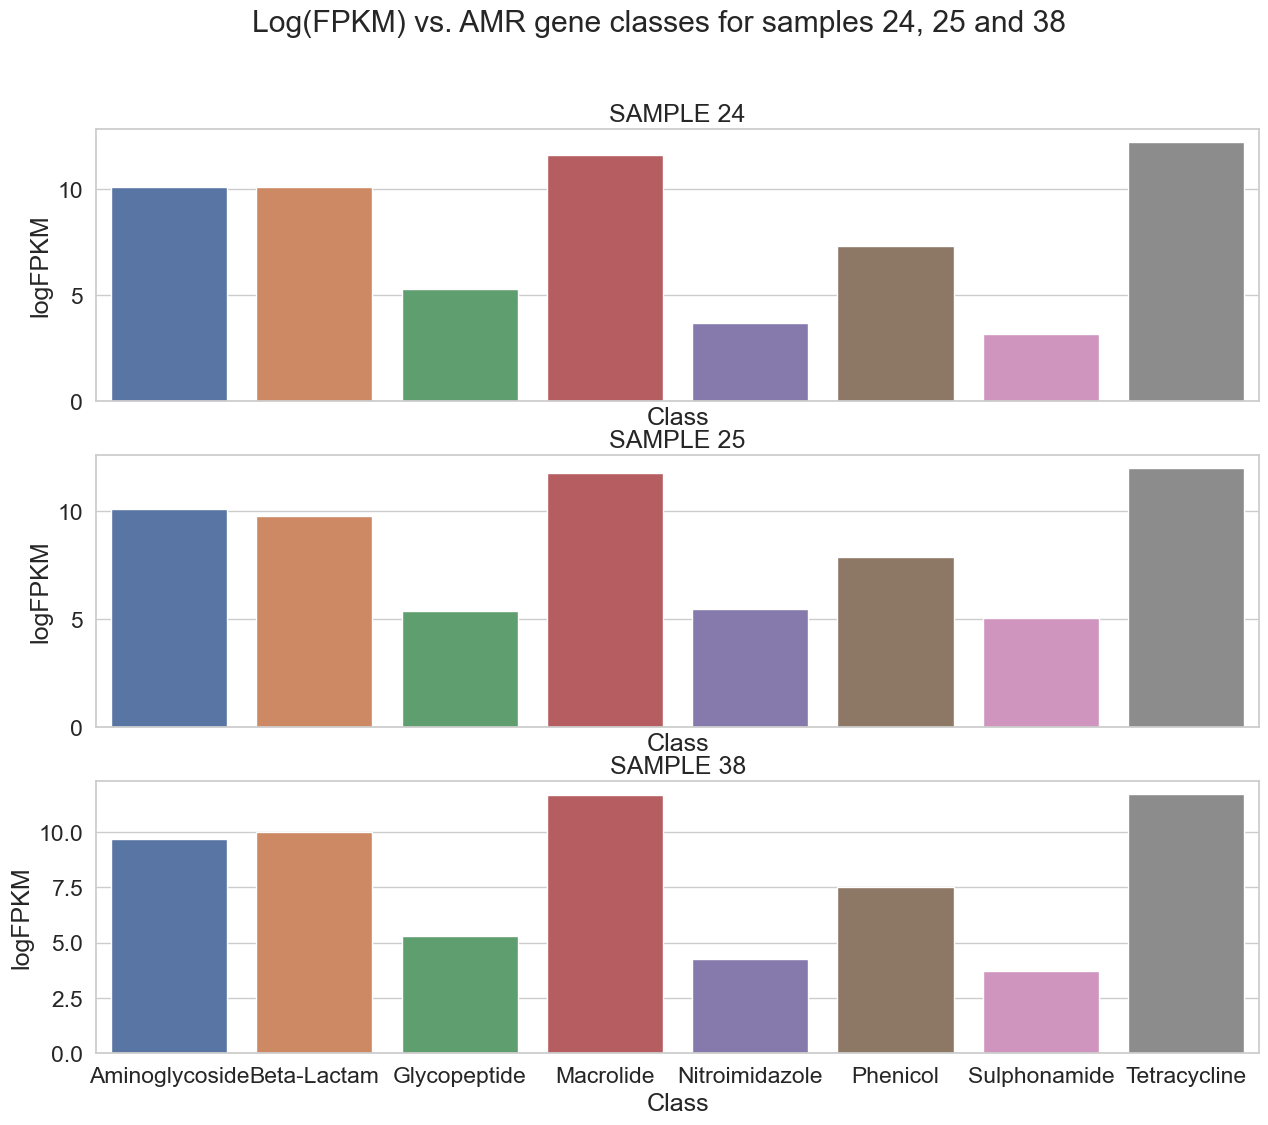

In [115]:
composite_plot_sns, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
composite_plot_sns.suptitle("Log(FPKM) vs. AMR gene classes for samples 24, 25 and 38")
axes[0].set_title("SAMPLE 24")
sns.barplot(data=grouped_24, ax=axes[0], x=grouped_24["Class"], y=grouped_24["logFPKM"])
axes[1].set_title("SAMPLE 25")
sns.barplot(data=grouped_25, ax=axes[1], x=grouped_25["Class"], y=grouped_25["logFPKM"])
axes[2].set_title("SAMPLE 38")
sns.barplot(data=grouped_38, ax=axes[2],  x=grouped_38["Class"], y=grouped_38["logFPKM"])

The plots reveal that tetracycline and macrolide are the most abundant AMR gene classes, with aminoglycoside and beta-lactam being the second most abundant AMR gene classes.

The actual log(FPKM) quantities seem *very* similar, which would indicate a similar AMR gene class composition between all 3 samples. However, due to the nature of the ALR values, they are technically *not* comparable between different samples.

For this purpose, we will compute CLR values in the following section.

### CLR

CLR values are computed by taking the original `resfinder_{24,25,38}` values, and performing 'closure' to them (a form of normalization).

Since we have used number of AMR fragments, we will use the total fragments (found in `fragmentCountAln` colunn of `resfinder` `*.mapstat` files).

Having performed closure, we amalgamate after AMR gene classes, as we did before with ARL. We now perform CLR. This can be done by dividing our fragment abundances by the geometric mean for each column, and log transforming.

In [86]:
# Find total fragment to perform closure
total_fragment_24 = pd.read_csv('./resfinder/resfinder_ERR2597524.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()
total_fragment_25 = pd.read_csv('./resfinder/resfinder_ERR2597525.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()
total_fragment_38 = pd.read_csv('./resfinder/kma_resfinder_38.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()
print("Total AMR gene fragments in sample 24:")
print(total_fragment_24)
print("Total AMR gene fragments in sample 25:")
print(total_fragment_25)
print("Total AMR gene fragments in sample 38:")
print(total_fragment_38)

Total AMR gene fragments in sample 24:
fragmentCountAln    54463
dtype: int64
Total AMR gene fragments in sample 25:
fragmentCountAln    136755
dtype: int64
Total AMR gene fragments in sample 38:
fragmentCountAln    22954
dtype: int64


**CLR values**

In [87]:
# Preparing dataframe with fragment abundance, for calculating CLR values
resfinder_clr = pd.DataFrame()
resfinder_clr["CLR(24)"] = resfinder_24["Abundance"]
resfinder_clr["CLR(25)"] = resfinder_25["Abundance"]
resfinder_clr["CLR(38)"] = resfinder_38["Abundance"]
resfinder_clr["Class"] = resfinder_24["Class"]
resfinder_clr.head()

,CLR(24),CLR(25),CLR(38),Class
0,117.0,532.0,78.0,Phenicol
1,30.0,66.0,19.0,Glycopeptide
2,6.0,33.0,1.0,Glycopeptide
3,1.0,24.0,1.0,Glycopeptide
4,1.0,1.0,3.0,Aminoglycoside


Resulting CLR values after applying closure and amalgamating after AMR gene classes:

In [88]:
# Compute CLR values for all samples
resfinder_clr = pd.DataFrame()

resfinder_clr["CLR(24)"] = resfinder_24["Abundance"]/total_fragment_24[0]
resfinder_clr["CLR(25)"] = resfinder_25["Abundance"]/total_fragment_25[0]
resfinder_clr["CLR(38)"] = resfinder_38["Abundance"]/total_fragment_38[0]
resfinder_clr["Class"] = resfinder_24["Class"]

resfinder_clr = resfinder_clr.groupby("Class").sum().transpose()

def gmean(row):
    """Calculate gmean."""
    return np.exp(
        (1 / len(row)) * np.log(row).sum()
    )

# calculate CLR
resfinder_clr = resfinder_clr.apply(lambda x: np.log(x / gmean(x)), axis=1).transpose()

resfinder_clr.reset_index(inplace=True)

display(resfinder_clr)

print("Sum of CLR values (they should sum to zero):")
print("sum(CLR(24)):")
print(resfinder_clr["CLR(24)"].sum())
print("sum(CLR(25)):")
print(resfinder_clr["CLR(25)"].sum())
print("sum(CLR(38)):")
print(resfinder_clr["CLR(38)"].sum())
print("Sums are small enough so that they are basically zero.")

,Class,CLR(24),CLR(25),CLR(38)
0,Aminoglycoside,1.970189,1.475739,1.523114
1,Beta-Lactam,2.096769,1.294787,1.947807
2,Glycopeptide,-2.056609,-2.408420,-2.125687
3,Macrolide,3.619219,3.283970,3.722264
4,Nitroimidazole,-4.974380,-3.694244,-4.477062
5,Phenicol,-0.567661,-0.516190,-0.434011
6,Sulphonamide,-4.974380,-3.583018,-4.477062
7,Tetracycline,4.886852,4.147376,4.320637


Sum of CLR values (they should sum to zero):
sum(CLR(24)):
1.7763568394002505e-15
sum(CLR(25)):
-3.552713678800501e-15
sum(CLR(38)):
-8.881784197001252e-16
Sums are small enough so that they are basically zero.


**Scatter plot of CLR values for all samples**

To use the python package `seaborn`'s 'hue' function, we need to perform a 'categorisation' by Samples, or 'pivot'. 

**This is is done in `R`**, and the resulting dataframe is exported to a csv, and loaded into the `python` workflow.

In [89]:
# Export clr dataframe to csv
resfinder_clr.to_csv("./resfinder/resfinder_clr.csv")

# Rcode for categorisation found in meta.R

# Import categorised csv
resfinder_clr_cat = pd.read_csv("./resfinder/resfinder_clr_cat.csv")

The following CLR plot is generated:

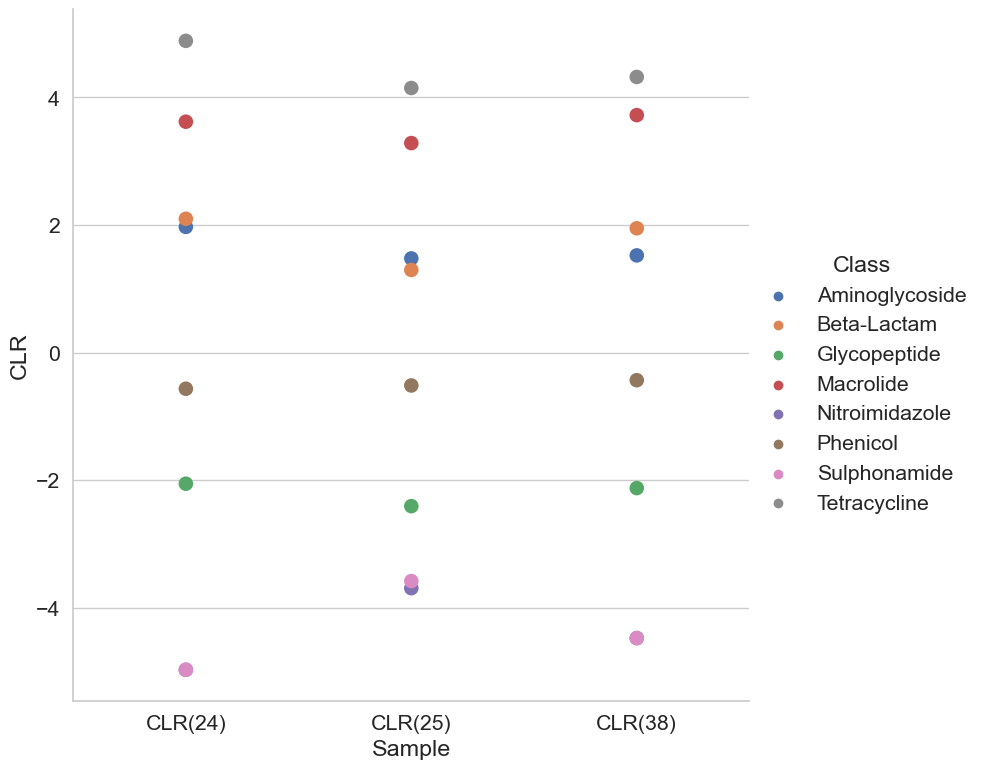

In [127]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.catplot(data=resfinder_clr_cat, x="Sample", y="CLR", hue="Class", s=110, jitter=False, height=8, aspect=8/8)

This plot demonstrates that although the samples vary in size, the AMR gene *composition* between them, varies very little. 

This supports the what was indicated from the log(FPKM) plots.

# Metagenomic bin quality study
***

The data used was generated from `CheckM2`, which assessed the quality of the bins based on contamination and completeness. The next step - de-replication (`dRep`), by default selected bins based on completeness >75 and contamination <25 - which are not particularly 'high' quality. Therefore, we decided to do investigate how fitting these criteria were, relative to our samples.

The data is obtained from the pre-treated CheckM2 quality report csv files. 

**All data analysis for this section was conducted in `R`**.
***
The following plot shows contamination vs. completeness for all the bins. The black rectangle, indicates all the bins selected by dRep. 

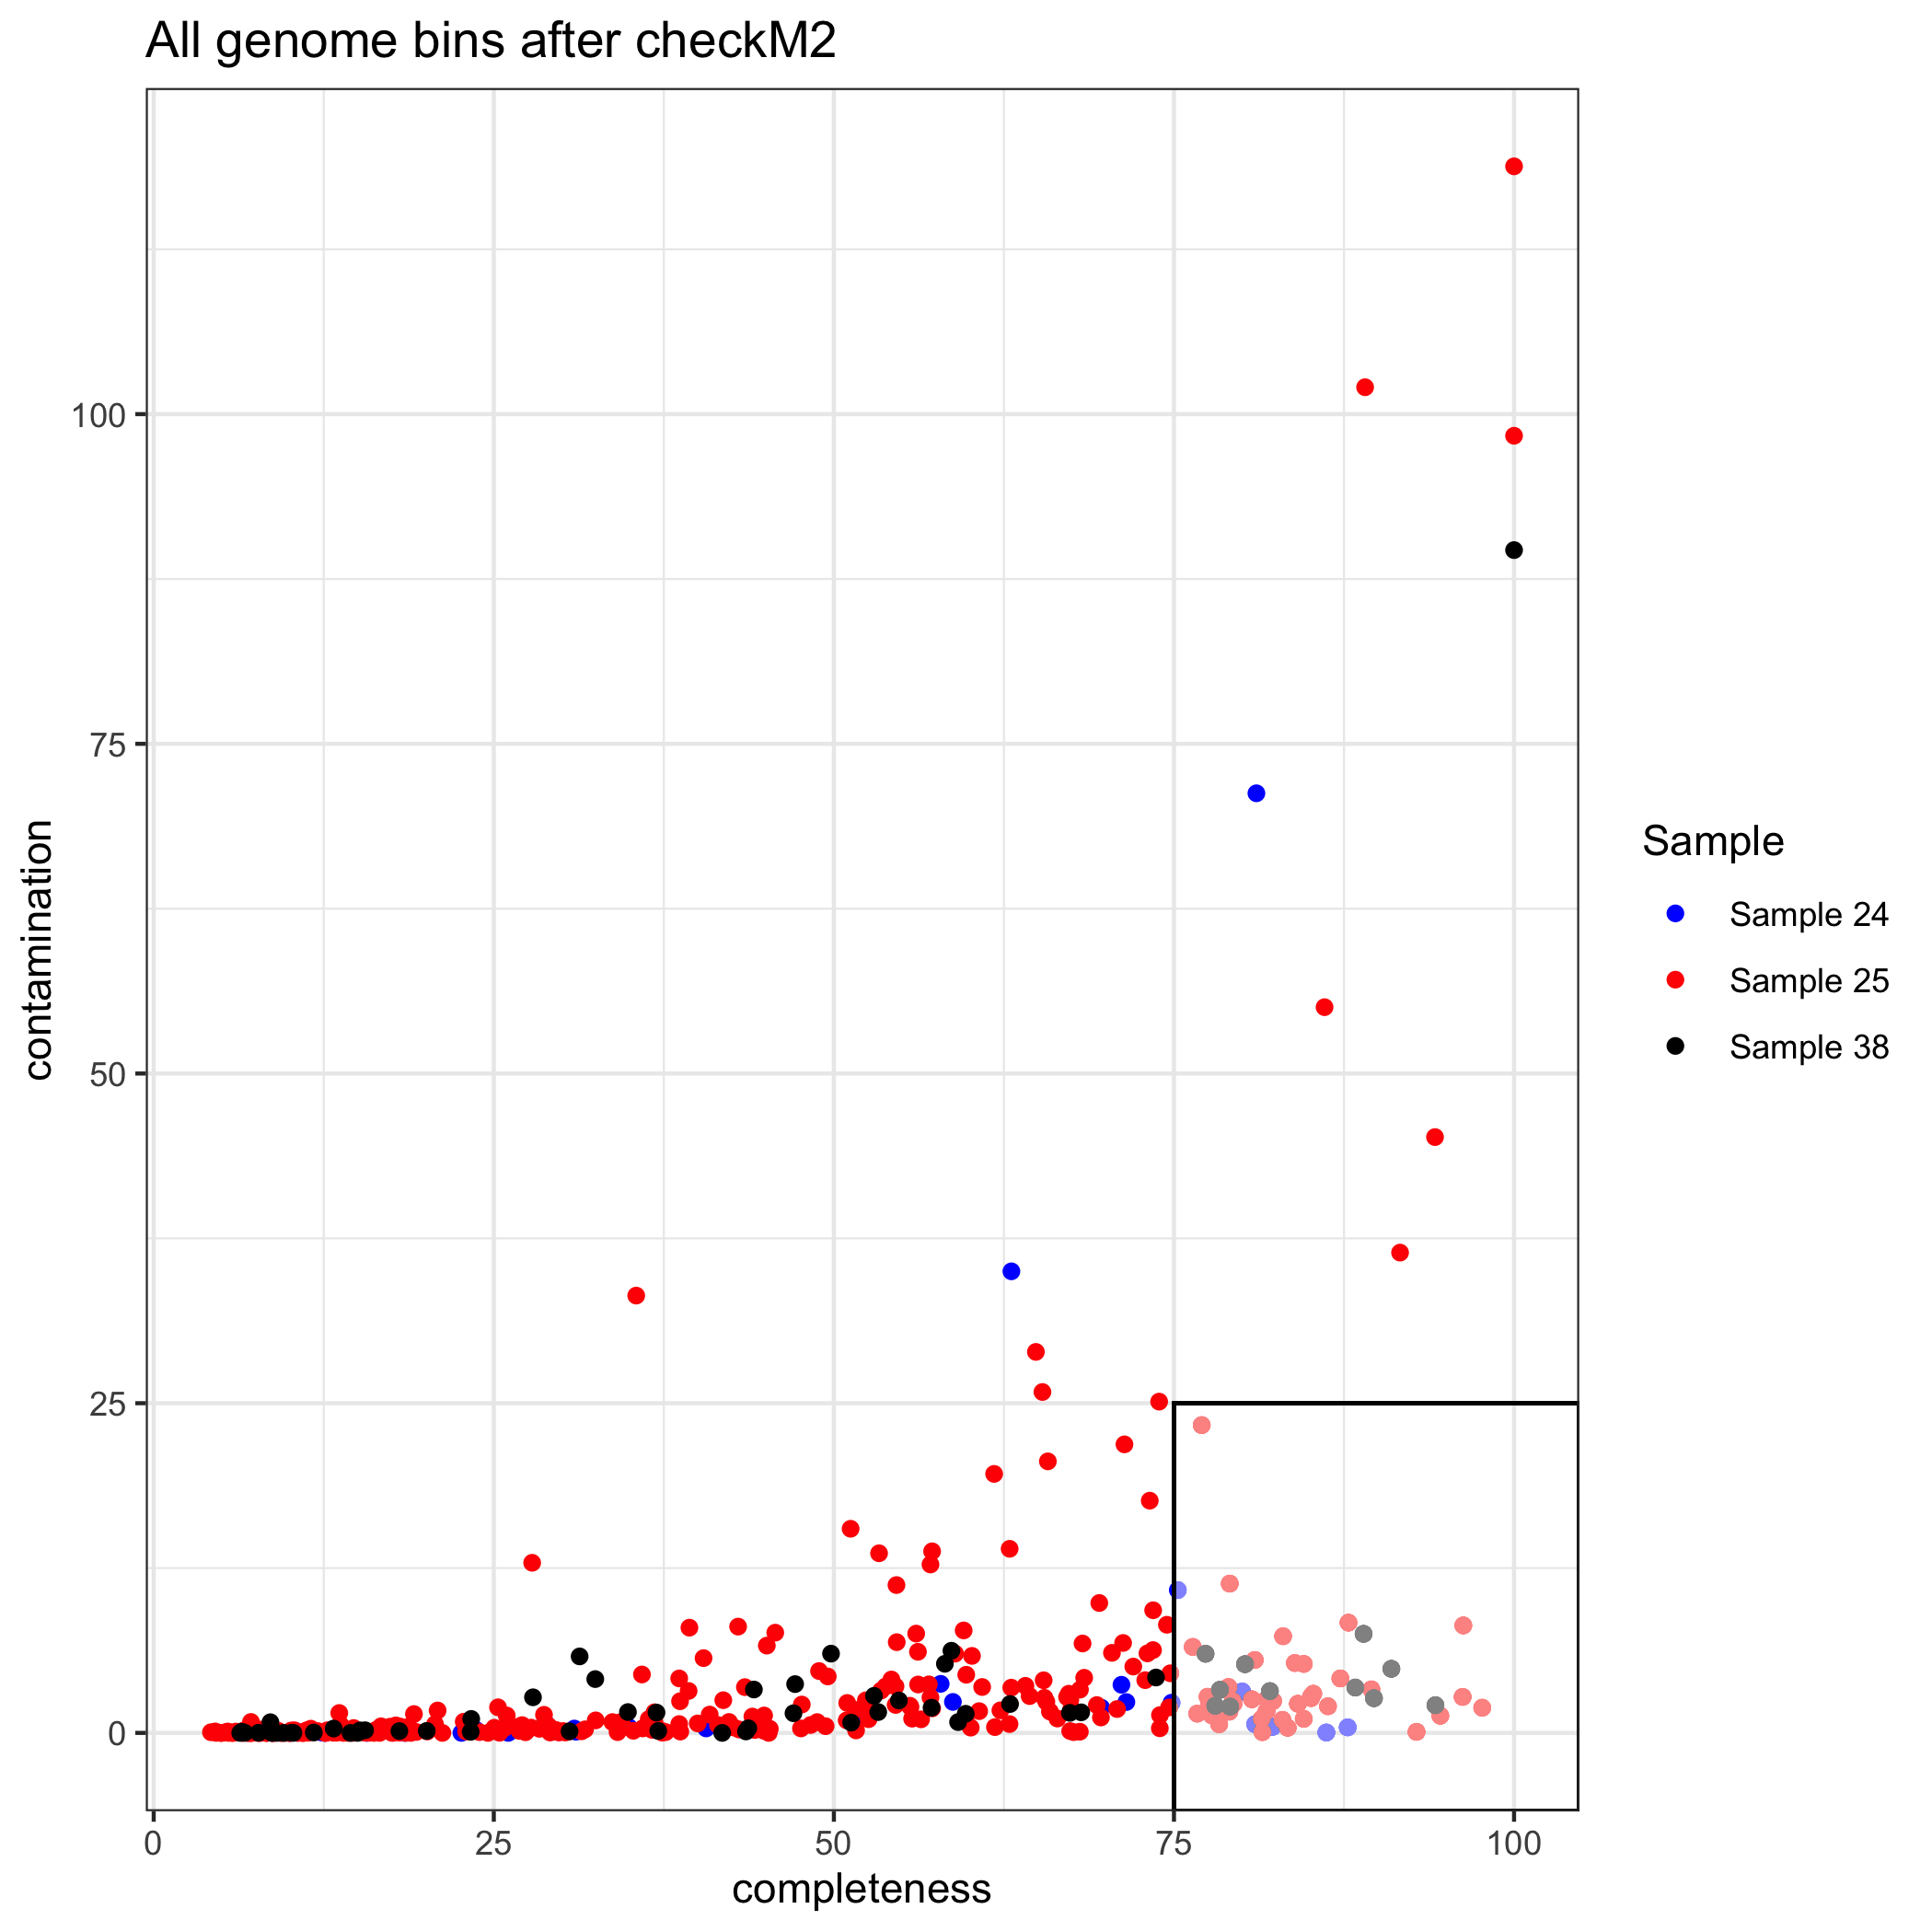

In [128]:
display.Image(filename="checkM2/all_bins.png", width=800, height=800)

The plot reveals that the vast majority of bins fall bellow dRep's already 'low' criteria. 

For clarity, we re-plotted the bins, only including those which passed the quality screening.

The light green section highlights literature-based suggestion for what a 'medium' quality thresholds and the dark green section highlights 'high' quality.

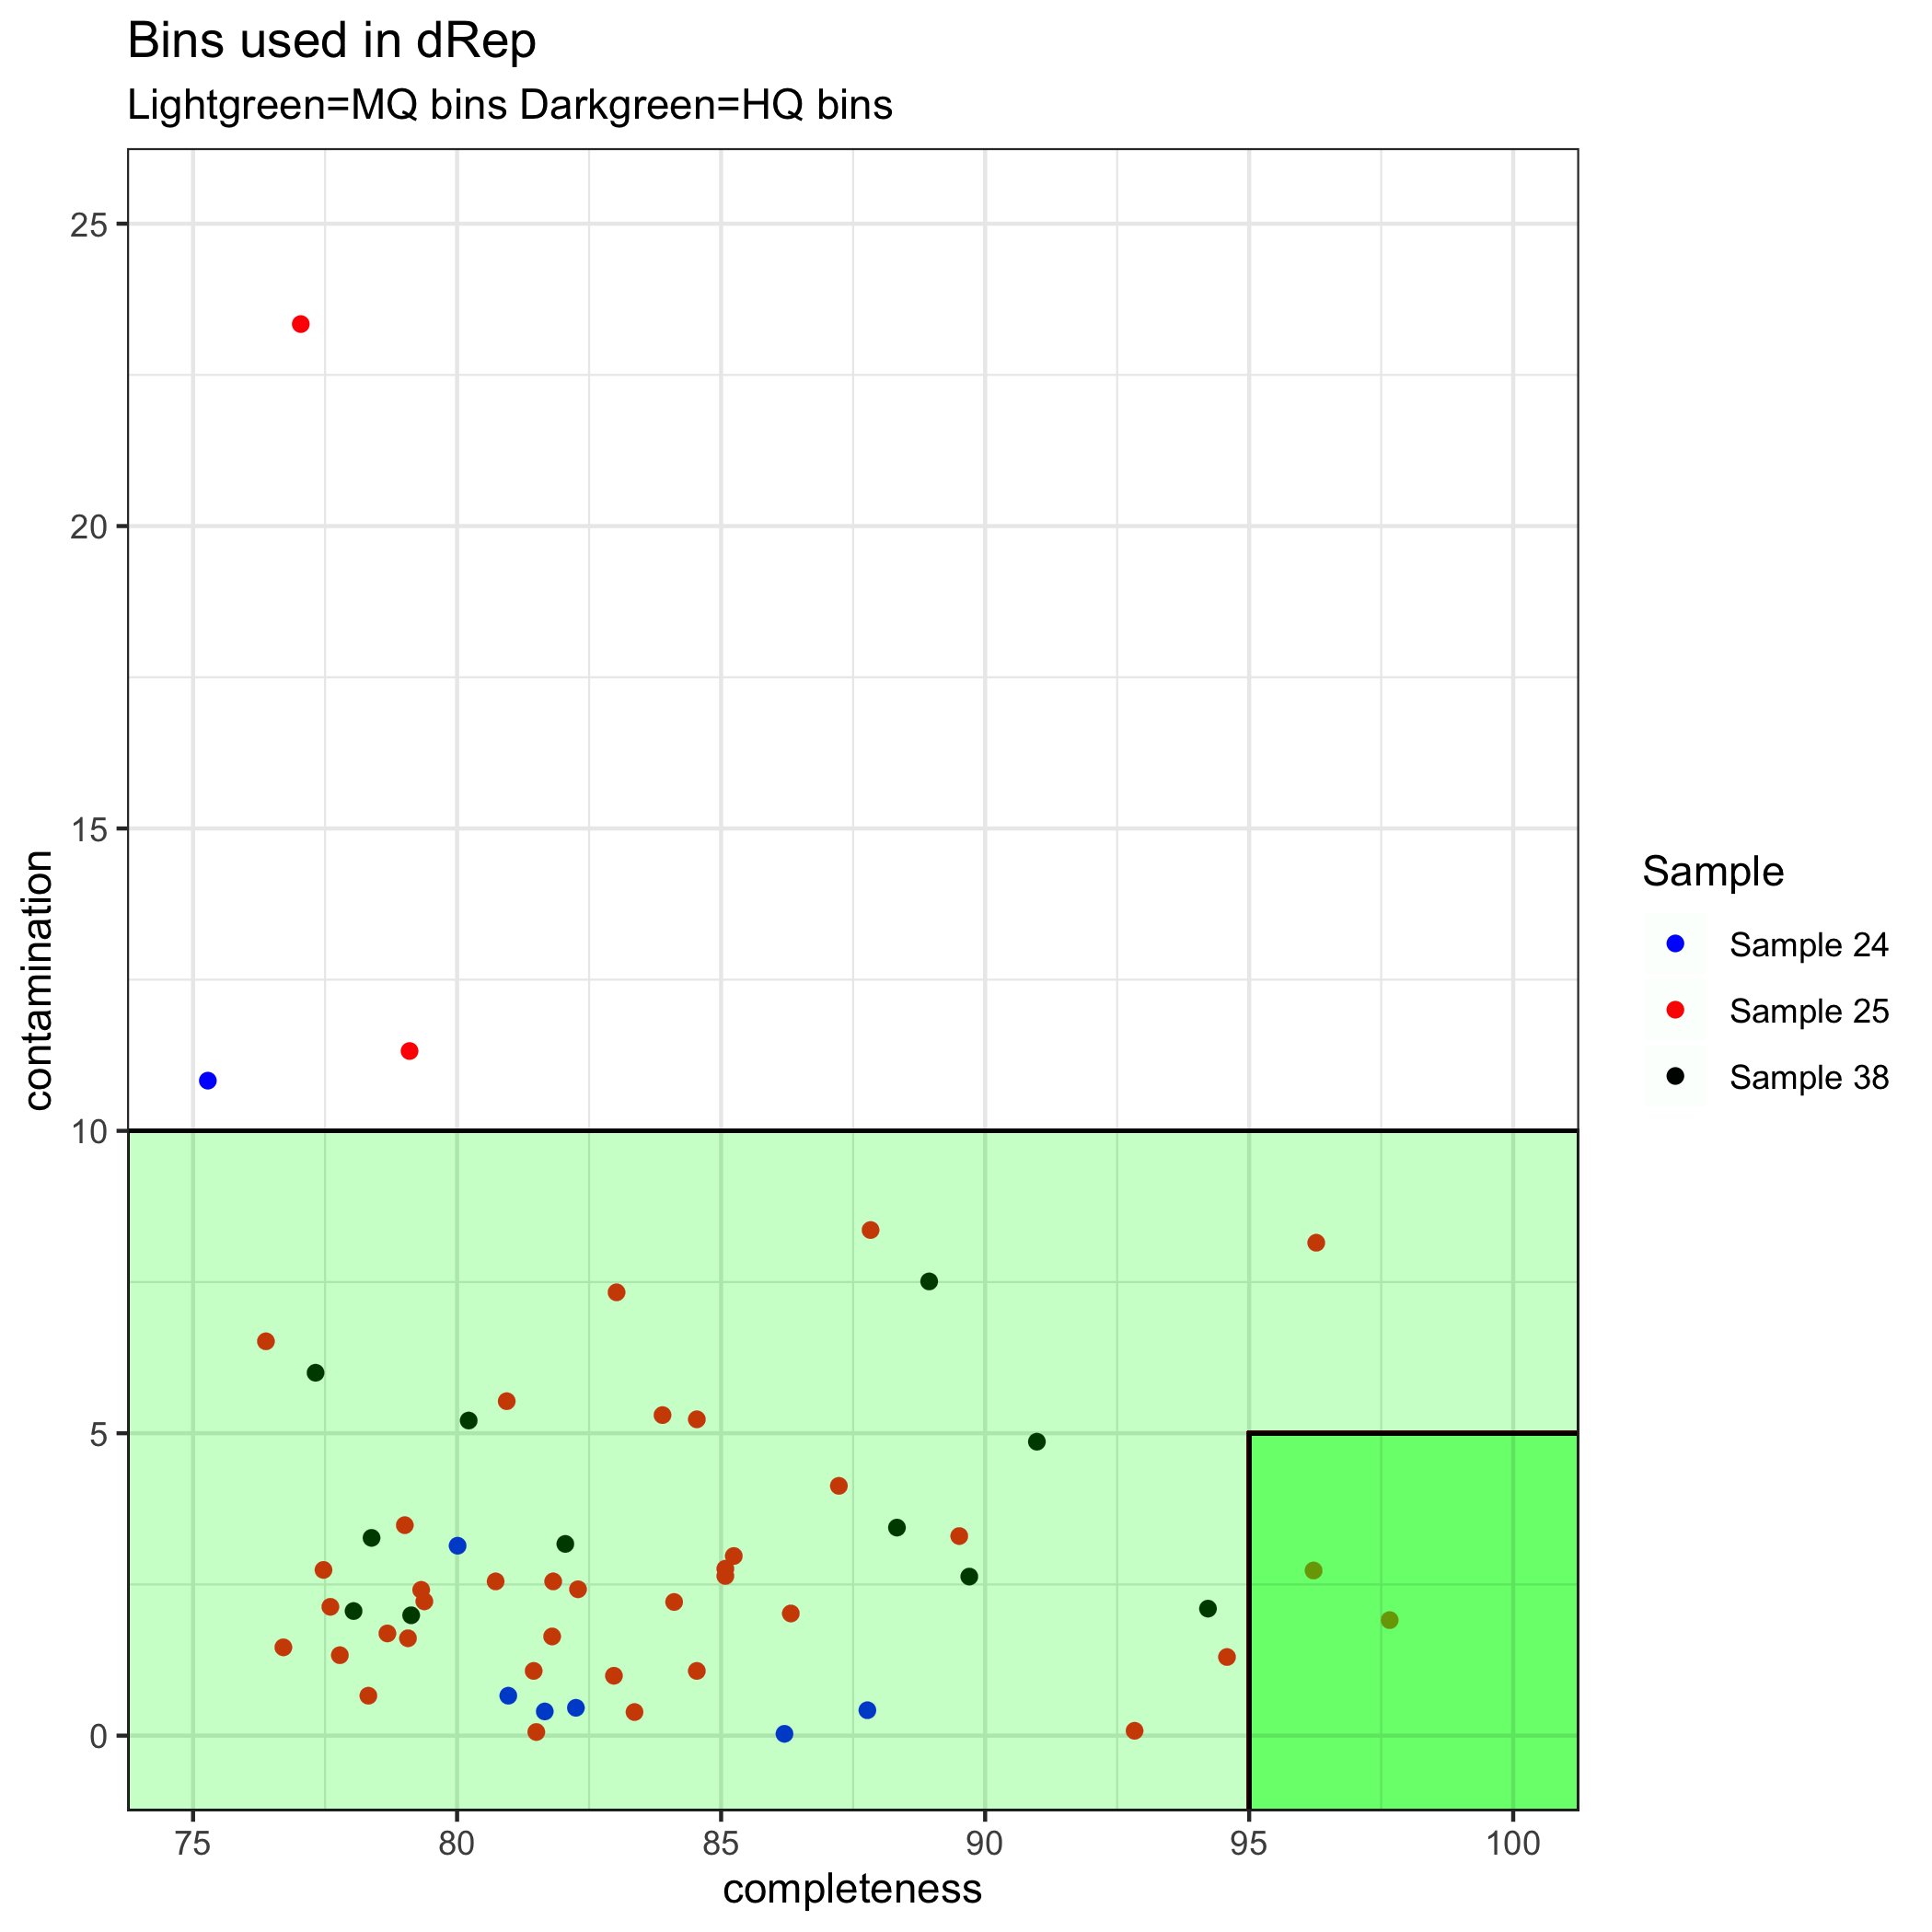

In [131]:
display.Image(filename="checkM2/dRep_bins.png", width=800, height=800)

As can be seen, the vast majority of bins - save for 3 outiers - fall comfortably within a literature-suggested 'medium' quality bin. On the contrary, only 2 bins for sample 25, qualified for 'high' quality bins. 

This indicates, that while majority of bins used in the final TaxID process do not quality as 'high' quality, all - except 3 - are within the 'medium' threshold, indicating that the bins are certainly not 'low' quality.

# Taxonomical annotation & identification (TaxID)
***

Having found investigated the AMR gene class distribution, we will now investigate bacterial taxonomical distribution. 

This will be done by looking at the taxonomical annotations, generated from `Gtdb-tk`.

The outputs have been pre-prepared, and are located in the `Gtdbtk` directory. 

In [79]:
##Load data
df38 = pd.read_csv("Gtdbtk/38_gtdbtk_taxid.csv").dropna()
df24 = pd.read_csv("Gtdbtk/24_gtdbtk_taxid.csv").dropna()
df25 = pd.read_csv("Gtdbtk/25_gtdbtk_taxid.csv").dropna()

#remove classification prefix from names (eg. d__*)
def strip_prefix(df):
    for i in df.columns:
        df[i] = df[i].map(lambda x: x.lstrip("_dpocfgs"))
    return df

df38 = strip_prefix(df38)
df24 = strip_prefix(df24)
df25 = strip_prefix(df25)


We use the value_counts function to count instances of each element at each classification level.

In [80]:
#Count number instances of each element
#Done in each column of the dataframe
def col_counts(df):
    col_count_list = []
    for i in df.columns:
        col_count_list.append(df[i].value_counts())
    return col_count_list

cc38 = col_counts(df38)
cc24 = col_counts(df24)
cc25 = col_counts(df25)


We make a dictionary with all names in all samples, so we can consistently color across samples.

In [81]:
#When we plot, we want each name to have unique and consistent coloring between all the samples.
#We use a dictionary for the color mapping. Each unique name will have a unique int to map to.

collected_names = [pd.DataFrame(cc24).columns.to_list(),pd.DataFrame(cc38).columns.to_list(),pd.DataFrame(cc25).columns.to_list()]
collected_names_list = list(chain(collected_names[0],collected_names[1],collected_names[2]))
unique_names=list(dict.fromkeys(collected_names_list))

name_dict = dict()
for i in range(len(unique_names)):
    name_dict[unique_names[i]] = i


We can now make a pie chart for each sample for the different classification levels.

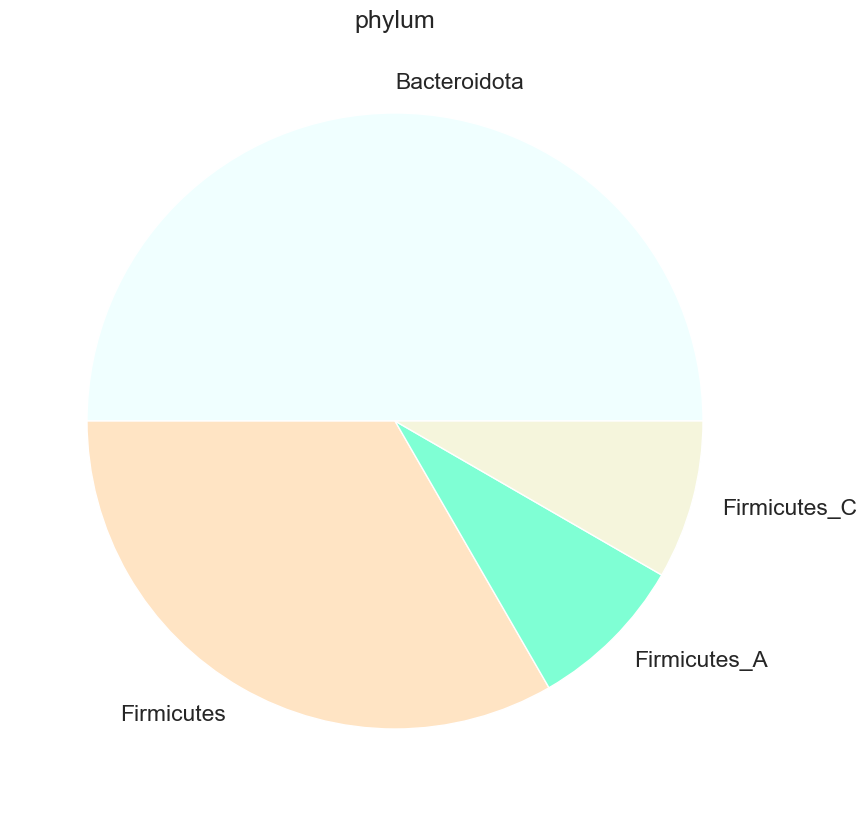

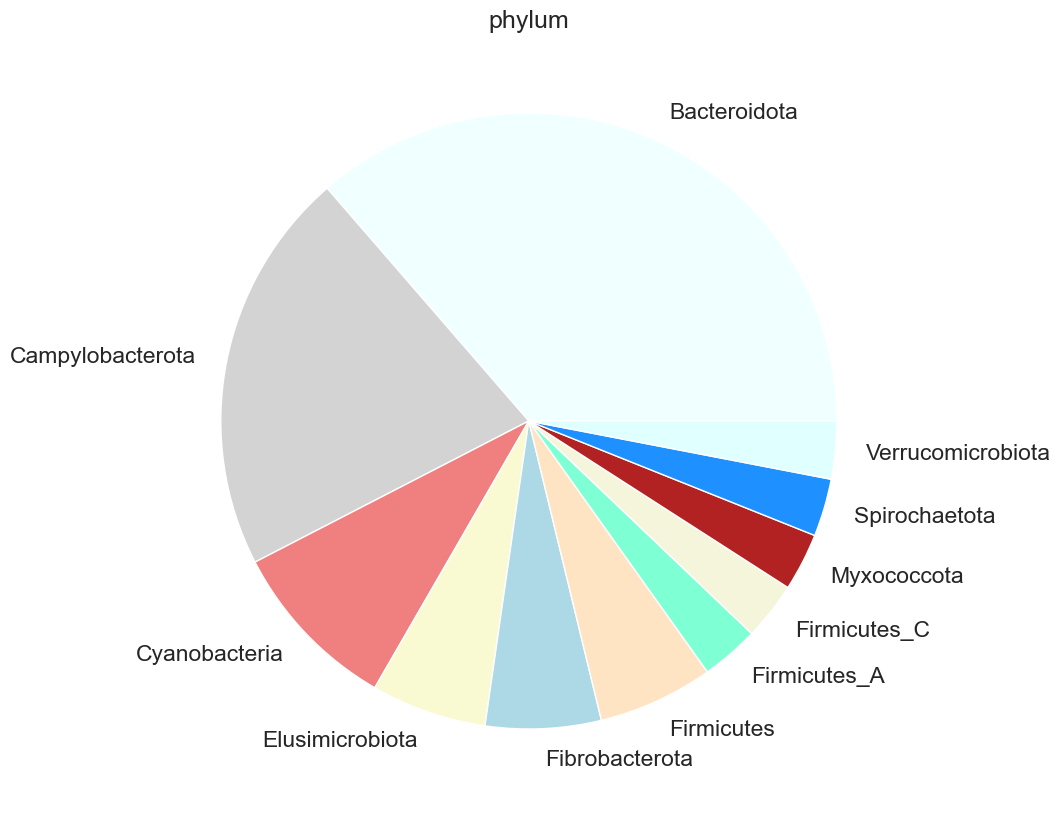

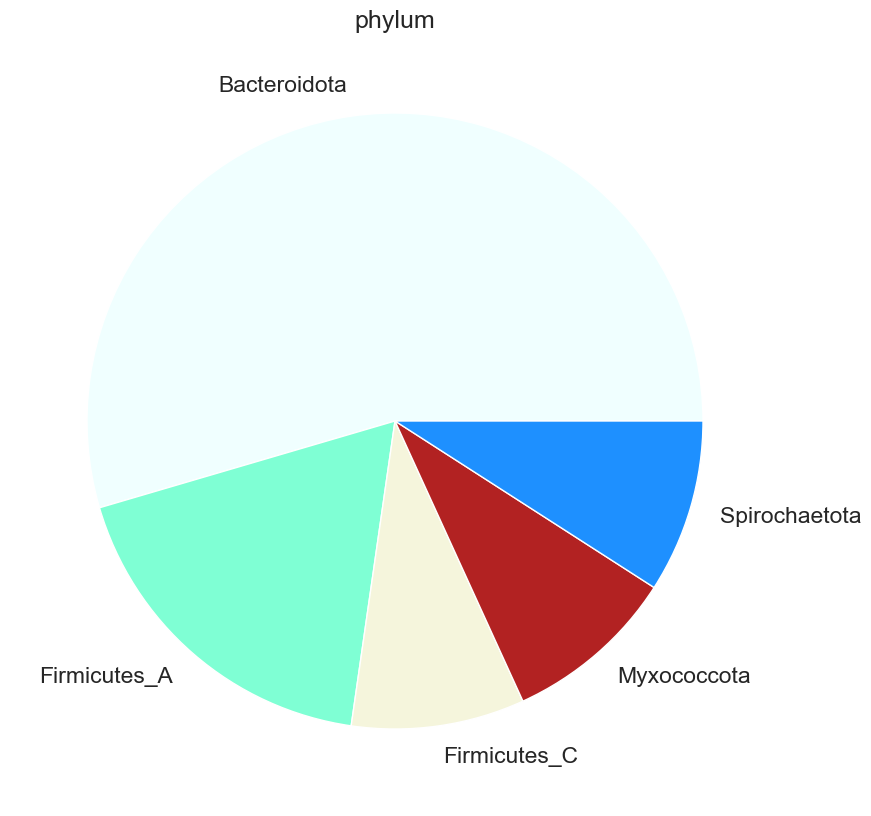

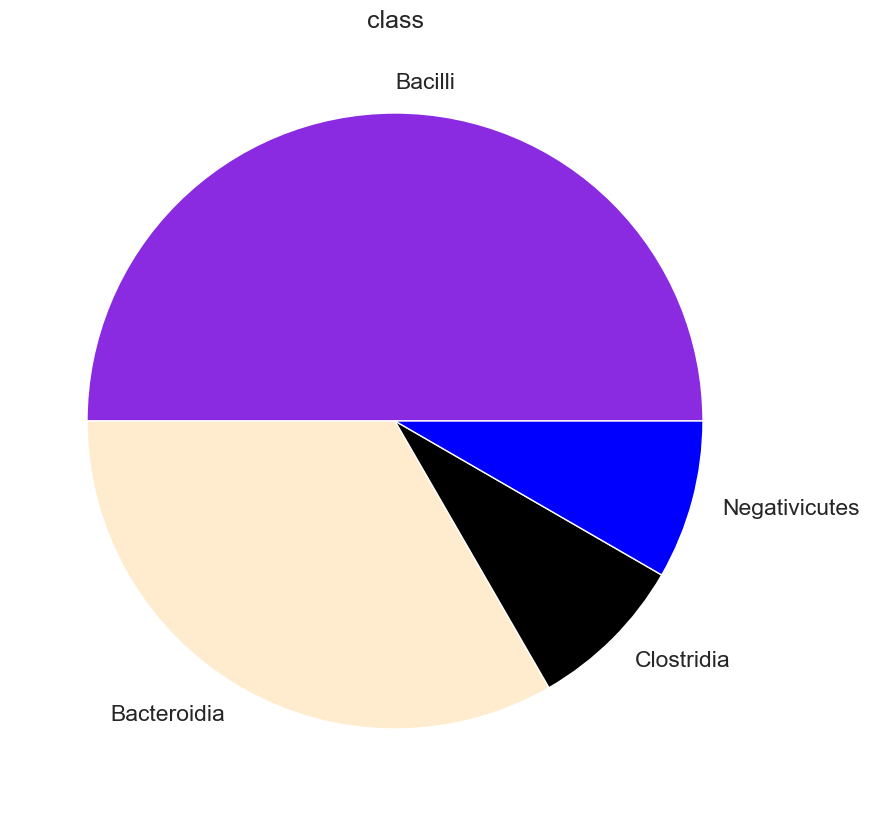

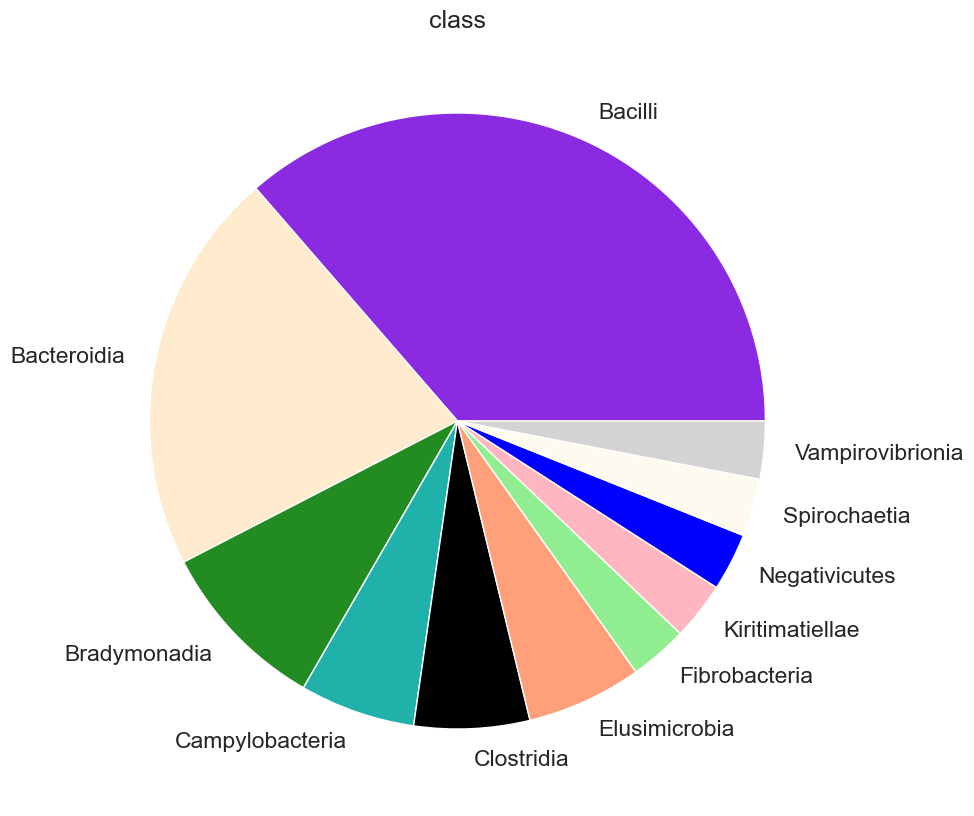

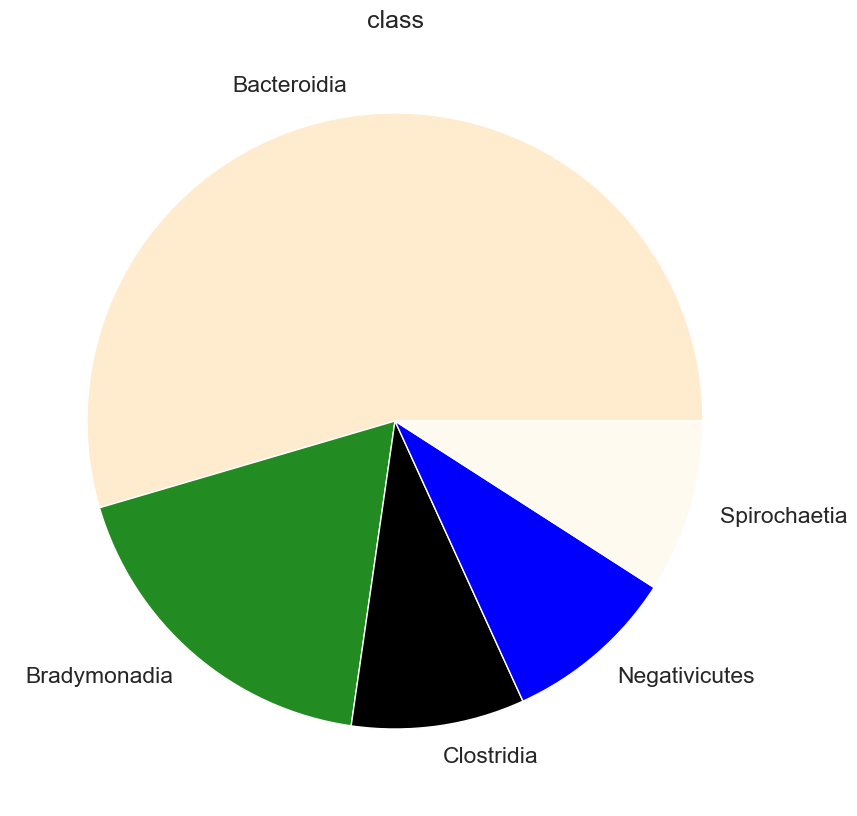

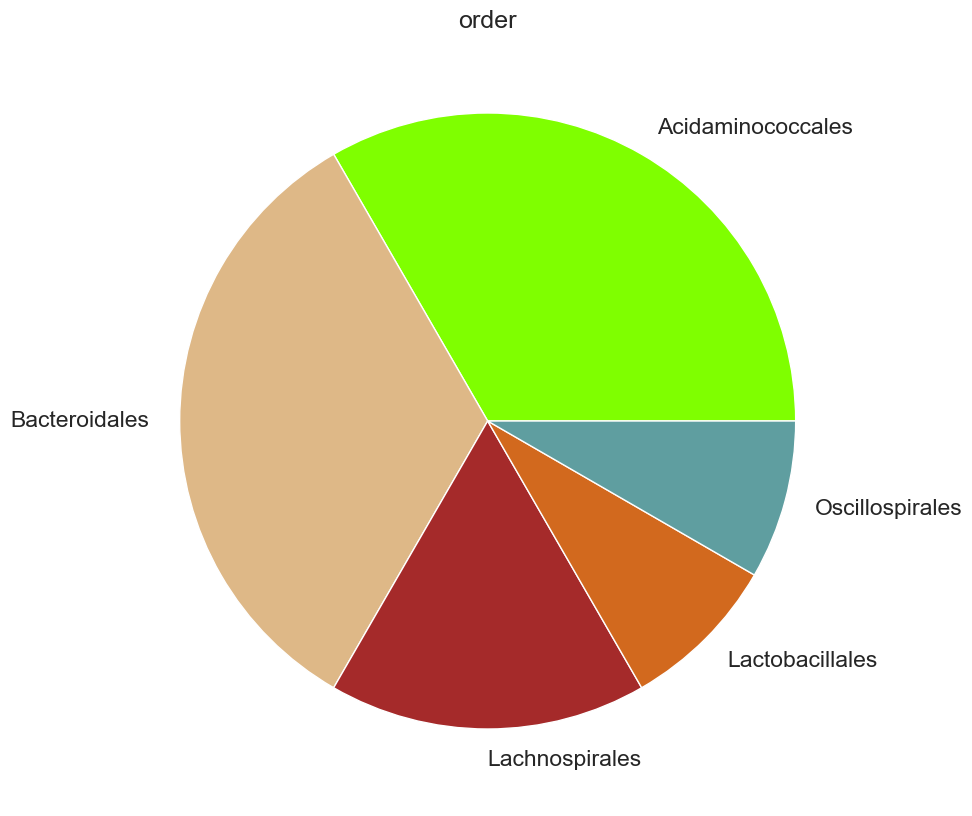

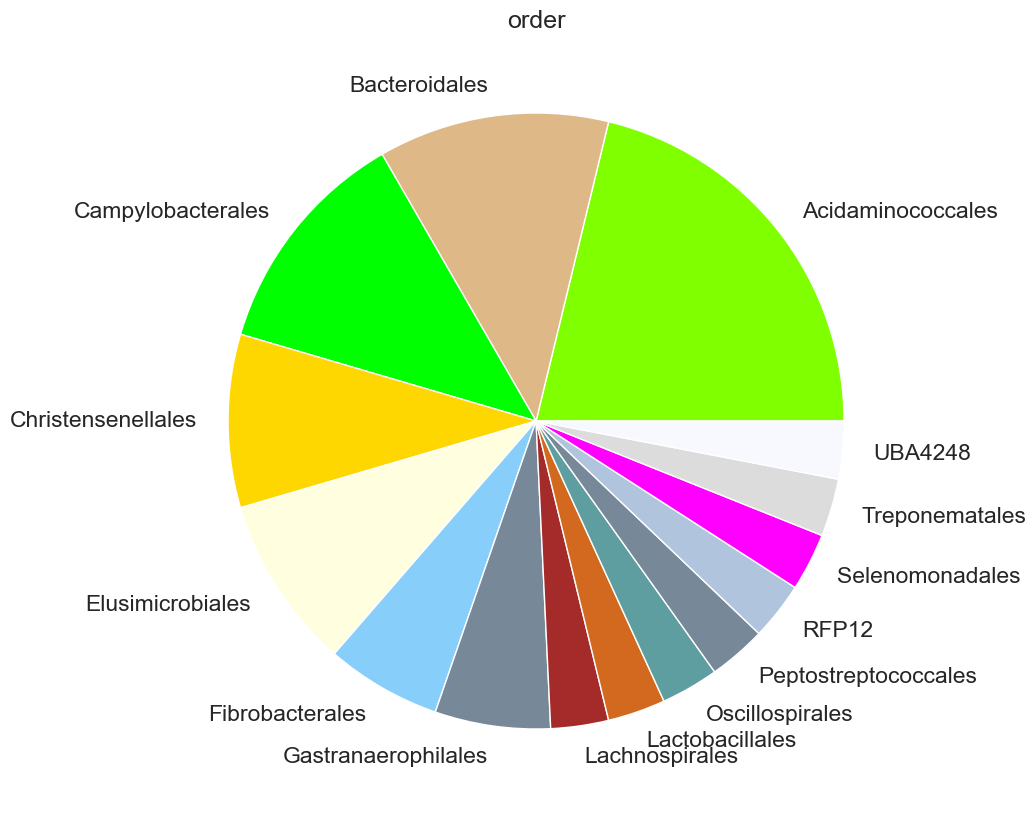

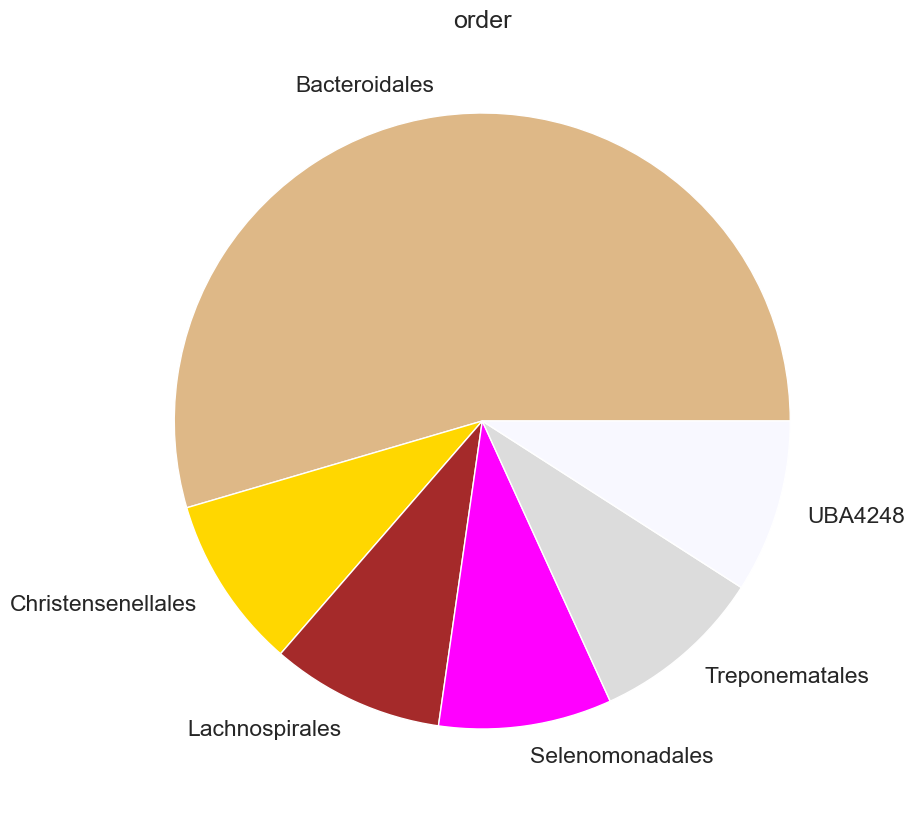

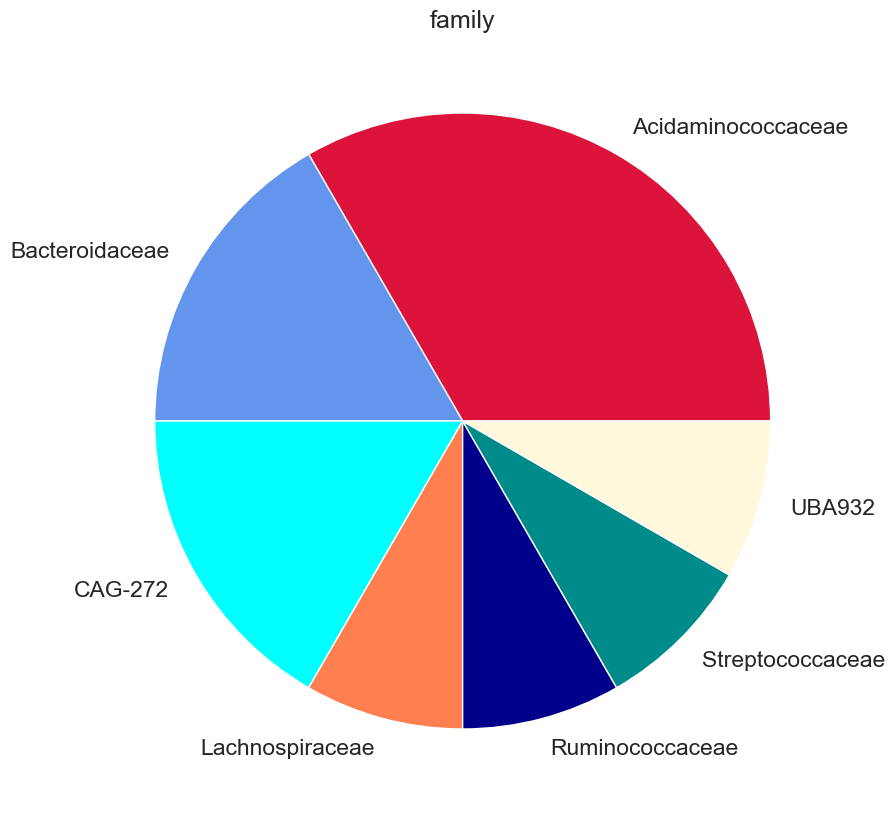

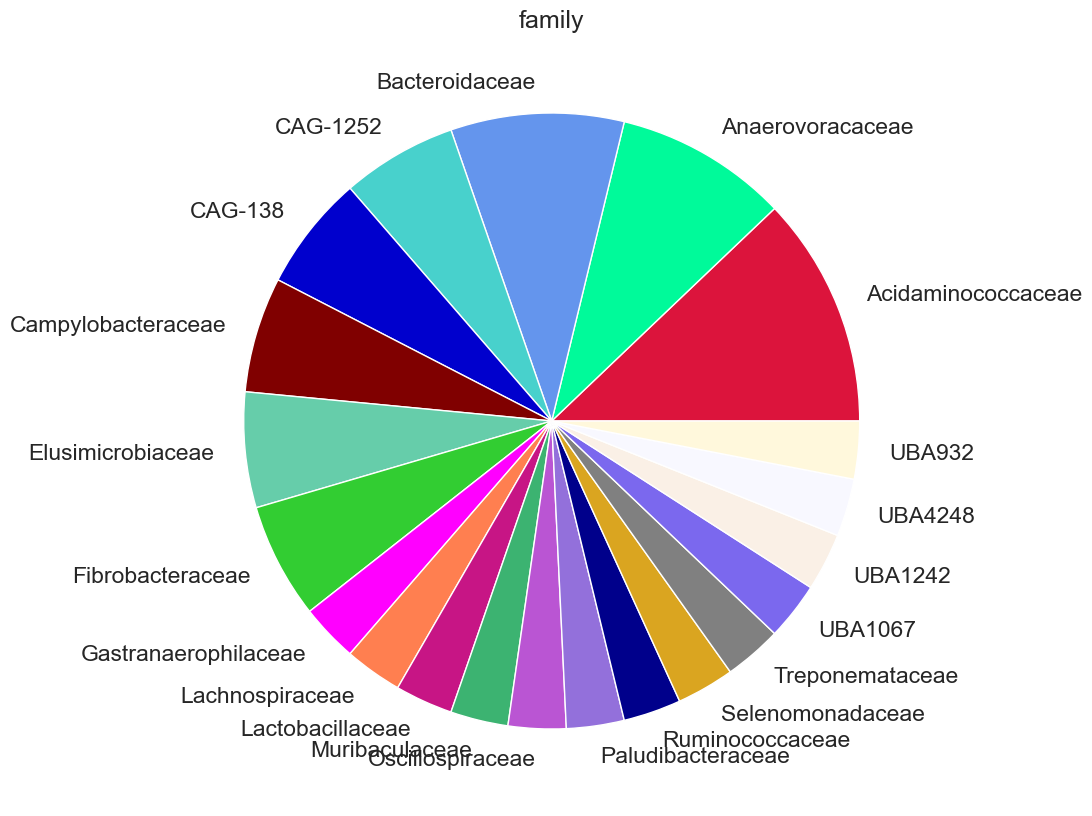

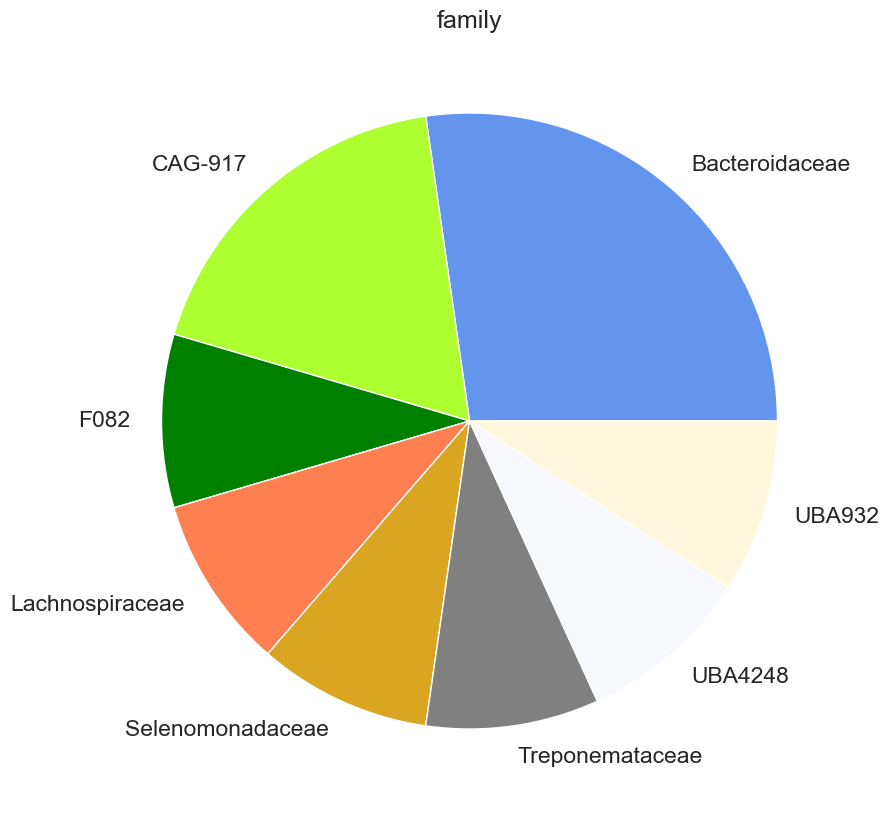

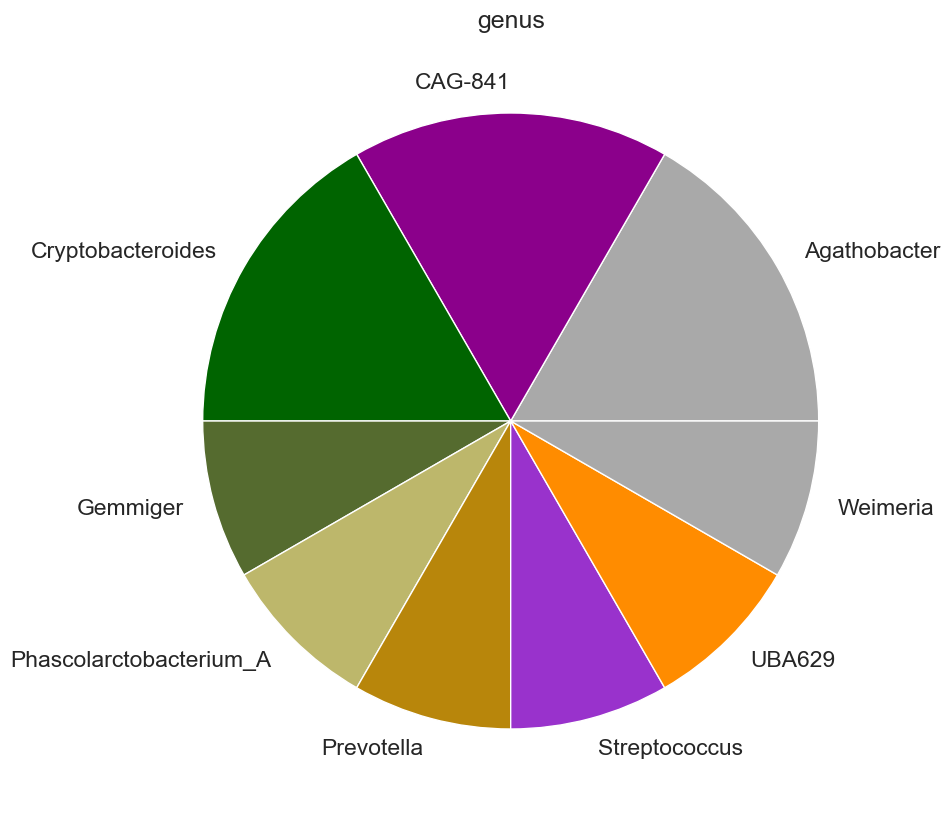

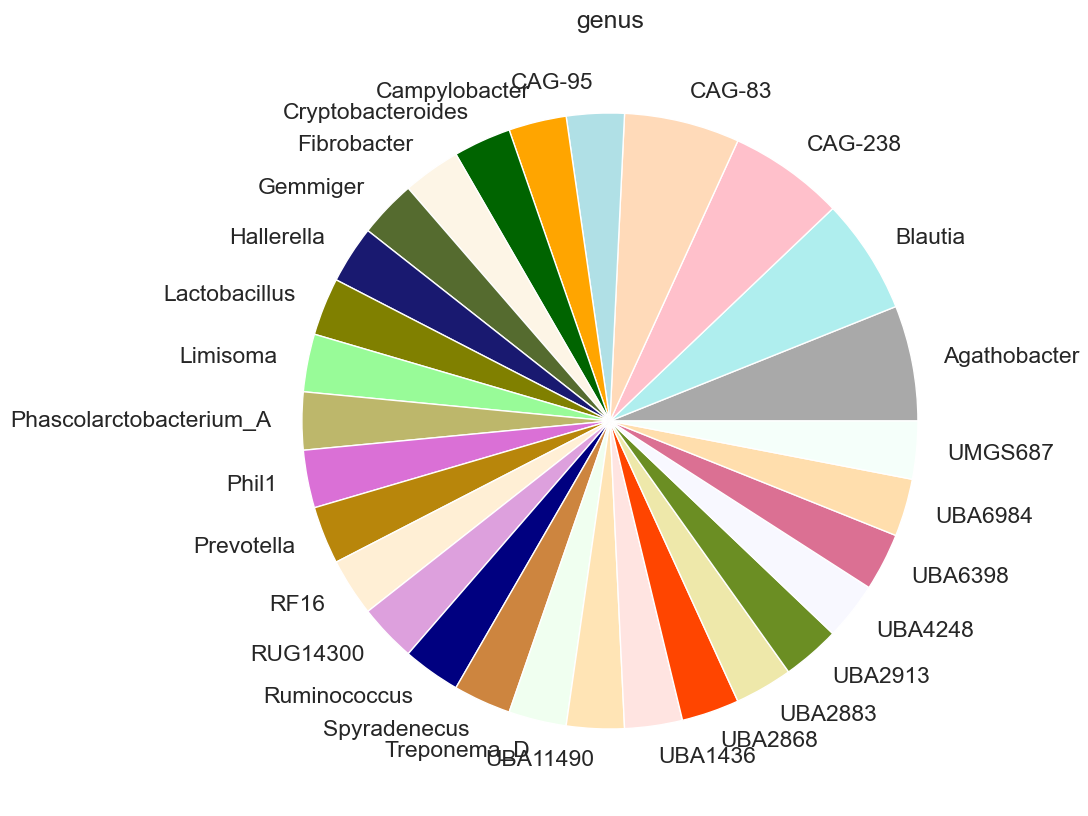

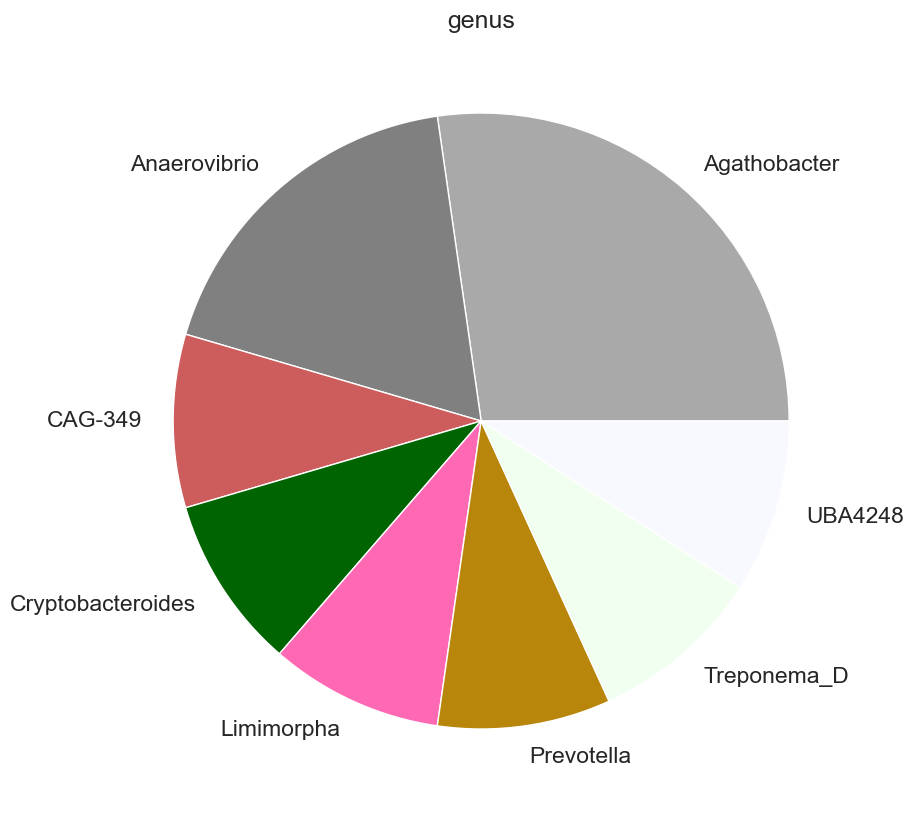

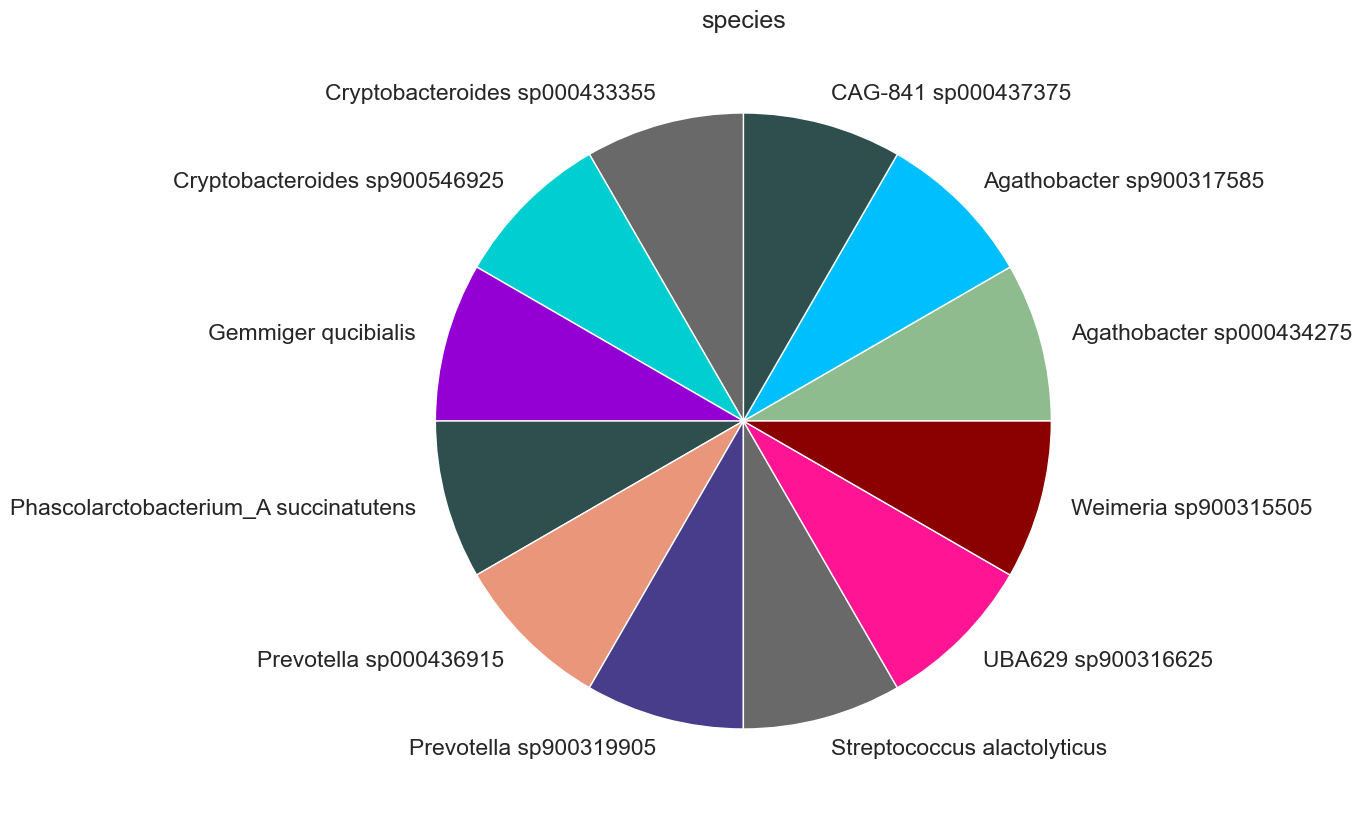

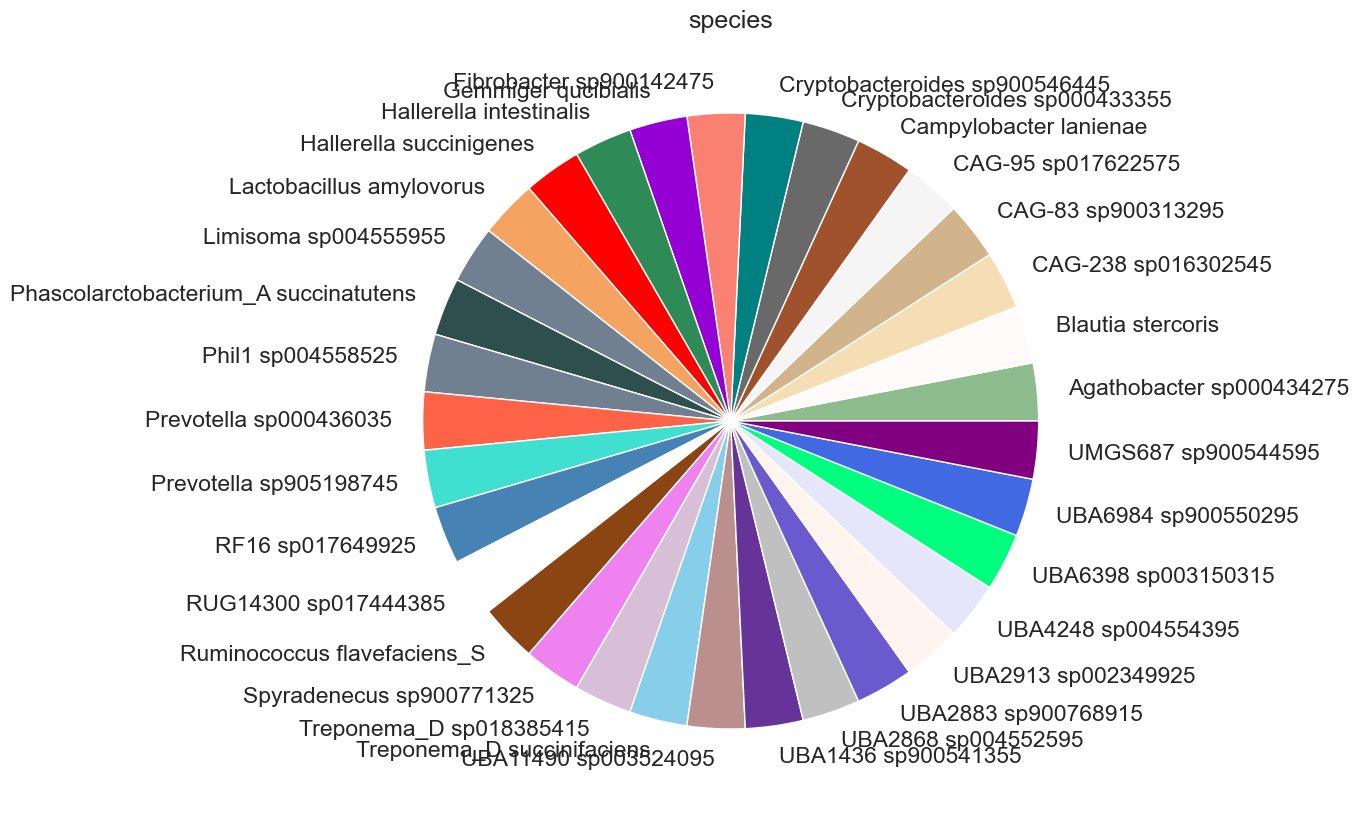

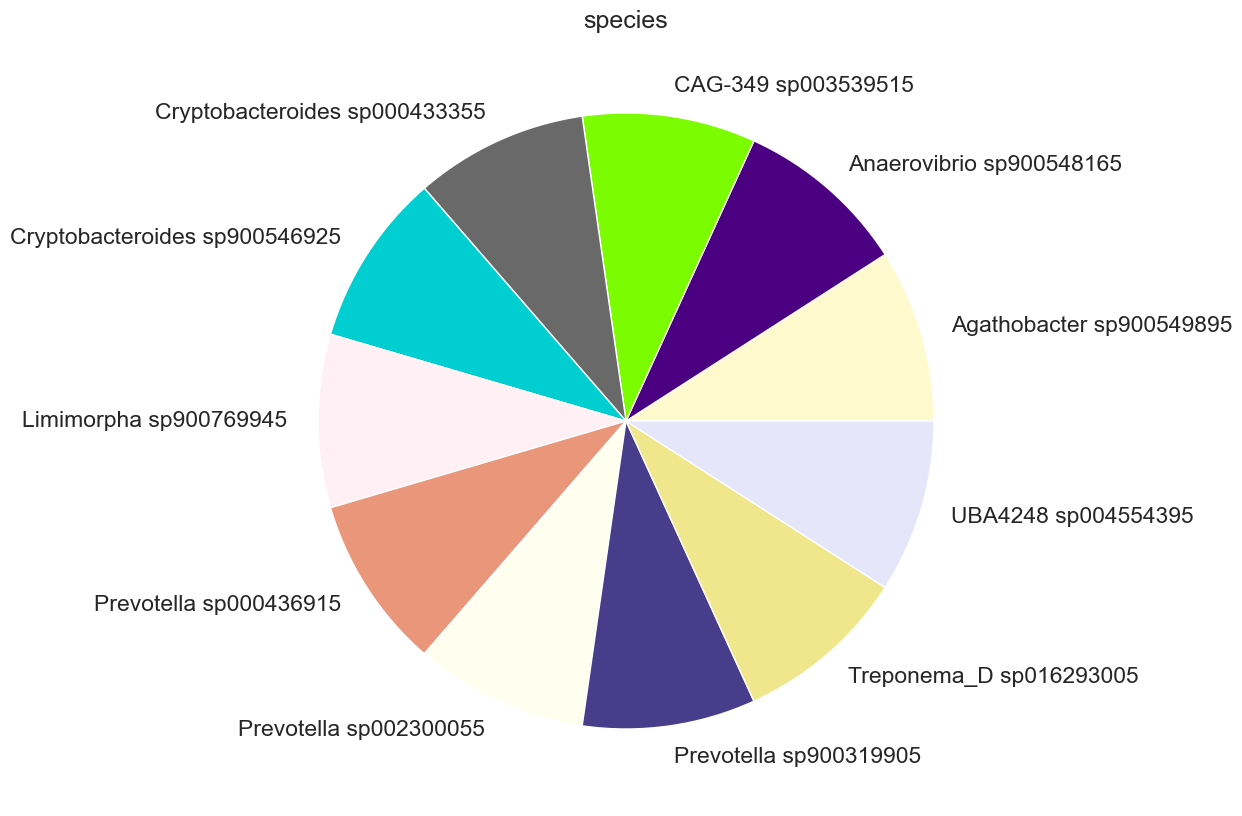

In [82]:
#Make pie-chart for each sample at a given classification level.
def subplots(level = 1):

    items = [cc24, cc25, cc38] #Use the column counts for each sample

    for q in range(len(items)):
        plt.rcParams['font.size'] = '6'#Set font size
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10)) #Make plot of size(10,10)

        lst = items[q] #Iterate trough each sample
        ax.pie(lst[level], #Use the given classification level
                  labels=lst[level].keys().sort_values(), #Use the sorted names for the level as labels.
                  colors=[list(mpl.colors.CSS4_COLORS.values())[j+2] for j in [name_dict[k] for k in sorted(lst[level].keys().to_list())]])
        #The line above is a bit complicated. It uses the name dict we made that can convert a name to an int.
        #It then uses that int to get a color by using the int as an index.
        #The colors are in a list given by matplotlib, which can be accessed by index
        #The offset (j+2) is set to make the colors more presentable
        ax.set_title(lst[level].name)
        plt.savefig("Gtdbtk/plots/"+str(level)+"_"+str(q)+".png")

for i in range(1,7):
    subplots(i)